# Sentiment Analysis for Stock Market Prediction #

Reference: https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178

### Imports and Packages ###

In [1]:
# For flair module
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# For text cleaning and preparation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

# For dealing with dataframe
import pandas as pd

# For making request to API
import requests

# For calling yahoo finance to get stock price 
import pandas_datareader as pdr
import datetime as dt
import dateutil.parser as dparser


2021-10-29 16:10:01,058 loading file /Users/aashish/.flair/models/sentiment-en-mix-distillbert_4.pt


### Model Properties ###

In [2]:
# Twitter Properties
TWITTER_SEARCH_URI = 'https://api.twitter.com/1.1/search/tweets.json'  # Twitter API search URI
TWITTER_BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAF8pUQEAAAAAL7QXs9hTVl4Zq2GE%2FYhVQeJ9kyE%3DUaV8oJRddqkRSZfDXYqI7qS2lBnfRV8lj2S0K6BPJeg4pPfRQf'   # Token for twitter API
TWITTER_MAX_SENTIMENT = 5000   # Maximum number of sentiments to fetch from twitter API

# Dataframe Properties
AUTHOR_NAME = 'Author_Name'
FOLLOWERS_COUNT = 'Followers_Count'
USER_MENTIONS = 'User_Mentions'         # Contains comma separated full name of the mentioned user
HASH_TAGS = 'Hash_Tags'                 # Contains comma separated hashtag texts
FRIENDS_COUNT = 'Friends_Count'
TEXT = 'Text'
RETWEET_COUNT = 'Retweet_Count'
CREATED_AT = 'Created_At'
SENTIMENT = 'Sentiment'
SENTIMENT_PROBABILITY = 'Sentiment_Probability'
STOCK_PRICE = 'Stock_Price'

# Stock Properties 
STOCK_NAME = 'tesla'    # Stock name to run model
STOCK_TICKER = 'TSLA'

## 1. Extract Raw Data ##
Calling Twitter API to get raw sentiments from users

In [3]:
# Parmeters to pass to twitter API
params = {
    'q': STOCK_NAME,
    'tweet_mode': 'extended',
    'lang': 'en',
    'count': TWITTER_MAX_SENTIMENT
}

# Call twitter API
response = requests.get(
    TWITTER_SEARCH_URI,
    params=params,
    headers={
        'authorization': 'Bearer '+ TWITTER_BEARER_TOKEN
})

# Get response in json
response_json = response.json()

## 2. Dataset Creation ##

### I. Converting twitter response json to dataset ###

In [4]:
# Defining dataframe with features 
df = pd.DataFrame(columns=[
    AUTHOR_NAME, 
    FOLLOWERS_COUNT, 
    USER_MENTIONS, 
    HASH_TAGS, 
    FRIENDS_COUNT, 
    TEXT, 
    RETWEET_COUNT, 
    CREATED_AT
])

In [5]:
# Converting twitter response json to dataset selecting required features
for status in response_json['statuses']:    
    df = df.append({
        AUTHOR_NAME: status['user']['name'],
        FOLLOWERS_COUNT: status['user']['followers_count'], 
        USER_MENTIONS: ','.join([ um['name'] for um in status['entities']['user_mentions']]),    # joined user mentions with comma separated value
        HASH_TAGS: ','.join([ ht['text'] for ht in status['entities']['hashtags']]),         # joined hashtags with comma separated value
        FRIENDS_COUNT: status['user']['friends_count'],
        TEXT: status['full_text'],
        RETWEET_COUNT: status['retweet_count'],
        CREATED_AT: status['created_at']
    }, ignore_index=True)

### II. Creating Stock Price label by using yahoo finance module ###

In [6]:
# Creating dictionary of date and stock price for particular stock
stock_price_dict = {}

for created_at in df[CREATED_AT]:
    parsed_date = dparser.parse(created_at, fuzzy=True)
    date = dt.datetime(parsed_date.year,parsed_date.month,parsed_date.day)
    if date not in stock_price_dict:
        stock_price = pdr.get_data_yahoo(STOCK_TICKER, start = date, end = date)['Close'][0]
        stock_price_dict[date] = stock_price

In [7]:
# Adding stock price label in the dataframe
stock_prices = []
for created_at in df[CREATED_AT]:
    parsed_date = dparser.parse(created_at, fuzzy=True)
    date = dt.datetime(parsed_date.year,parsed_date.month,parsed_date.day)
    stock_prices.append(stock_price_dict[date])

df[STOCK_PRICE] = stock_prices

In [8]:
# Displaying top 5 record for visualizing
df.head(5)

,Author_Name,Followers_Count,User_Mentions,Hash_Tags,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price
0,Jeff Grevenkamp,81,Gary Black,,174,RT @garyblack00: Great article about Leo KoGua...,23,Fri Oct 29 21:10:02 +0000 2021,1114
1,david72626,0,,,0,Check out these new Market Research Reports:\n...,0,Fri Oct 29 21:10:01 +0000 2021,1114
2,TradingView Español 🇪🇸,20543,,TSLA,6000,"#TSLA - tesla , msft y facebook - TradingView ...",0,Fri Oct 29 21:10:00 +0000 2021,1114
3,Tesla Speed Babe,337,Vishal Mistry 💭,,309,RT @teslaunivrse: I started investing in $TSLA...,1,Fri Oct 29 21:10:00 +0000 2021,1114
4,BI,1107,shawté,,624,RT @icraveguap: tired of paying for this expen...,1,Fri Oct 29 21:10:00 +0000 2021,1114


## 3. Feature Engineering ##

### I. Applying text cleaning methods ###

In [9]:
# Function to clean text by applying several text cleaning methods
def clean_prepare_text(text):
    # 1. Clean the text - cleaning special character
    filtered_text = text.replace("\r", " ").replace("\n", " ").replace("  ", " ")

    # 2. Remove all the punctuations
    for punct_sign in list("?:!,;\""):
        filtered_text = filtered_text.replace(punct_sign, '')

    # 3. Convert to lowercase 
    filtered_text = filtered_text.lower()

    # 4. Remove stopwords
    filtered_text = " ".join([text for text in filtered_text.split(" ") if text not in stopwords.words('english')])

    # 5. Remove meaningles words 
    filtered_text = filtered_text.replace("\'ve", '').replace("\'s", '').replace("\'m", '').replace("\'t", '')

    # 6.a. Stemming
    filtered_text = " ".join([stemmer.stem(text) for text in filtered_text.split(" ")])

    # 6.b. lemmatization
    filtered_text = " ".join([lemmatizer.lemmatize(text) for text in filtered_text.split(" ")])

    return filtered_text


In [10]:
# Clean and Prepare text for further processing
df[TEXT] = [clean_prepare_text(text) for text in df[TEXT]]

In [11]:
df[TEXT][0]

'rt @garyblack00 great articl leo koguan tsla’ 3rd largest individu sh made $7b $tsla invest far. https/…'

### II. Creating Sentiment Feature by using pretrained 'flair' Model ###

In [12]:
sentiments = []
sentiment_probabilities = []

for text in df[TEXT]:
    sentence = flair.data.Sentence(text)
    sentiment_model.predict(sentence)
    
    probability = sentence.labels[0].score  # numerical value 0-1
    sentiment = sentence.labels[0].value    # 'POSITIVE' or 'NEGATIVE'
    
    sentiments.append(sentiment)
    sentiment_probabilities.append(probability)
    
df[SENTIMENT] = sentiments
df[SENTIMENT_PROBABILITY] = sentiment_probabilities

In [13]:
# Displaying top 5 record for visualizing
df.head(5)

,Author_Name,Followers_Count,User_Mentions,Hash_Tags,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
0,Jeff Grevenkamp,81,Gary Black,,174,rt @garyblack00 great articl leo koguan tsla’ ...,23,Fri Oct 29 21:10:02 +0000 2021,1114,POSITIVE,0.981909
1,david72626,0,,,0,check new market research report ac servomotor...,0,Fri Oct 29 21:10:01 +0000 2021,1114,POSITIVE,0.774058
2,TradingView Español 🇪🇸,20543,,TSLA,6000,#tsla - tesla msft facebook - tradingview - h...,0,Fri Oct 29 21:10:00 +0000 2021,1114,POSITIVE,0.801314
3,Tesla Speed Babe,337,Vishal Mistry 💭,,309,rt @teslaunivrs start invest $tsla last year w...,1,Fri Oct 29 21:10:00 +0000 2021,1114,POSITIVE,0.978980
4,BI,1107,shawté,,624,rt @icraveguap tire pay expens as ga let order...,1,Fri Oct 29 21:10:00 +0000 2021,1114,NEGATIVE,0.968201


In [14]:
import matplotlib.pyplot as plt
newdf= df.groupby("Sentiment").count()


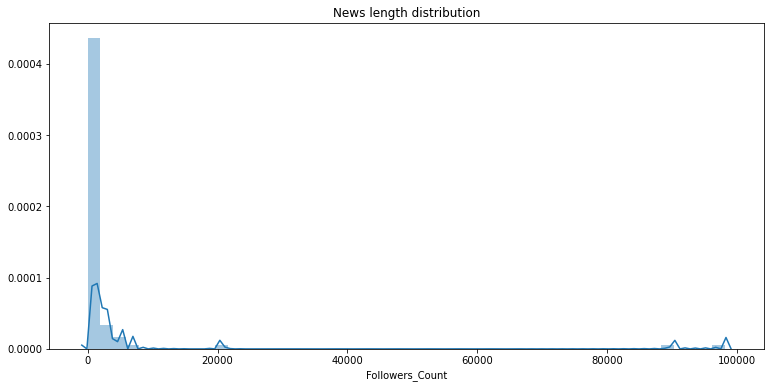

In [15]:
import seaborn as sns
plt.figure(figsize=(12.8,6))
sns.distplot(df['Followers_Count']).set_title('News length distribution');



In [16]:
#find the stock values by days

In [17]:
import datetime
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(100)]

In [18]:
date_list

[datetime.datetime(2021, 10, 29, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 28, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 27, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 26, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 25, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 24, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 23, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 22, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 21, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 20, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 19, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 18, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 17, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 16, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 15, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 14, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 13, 16, 10, 17, 669019),
 datetime.datetime(2021, 10, 12, 16, 10, 17, 669019),
 datetime.datetime(2021, 10,

In [19]:
# Creating dictionary of date and stock price for particular stock
stock_price_dict = {}

for created_at in df[CREATED_AT]:
    parsed_date = dparser.parse(created_at, fuzzy=True)
    date = dt.datetime(parsed_date.year,parsed_date.month,parsed_date.day)
    if date not in stock_price_dict:
        stock_price = pdr.get_data_yahoo(STOCK_TICKER, start = date, end = date)['Close'][0]
        stock_price_dict[date] = stock_price

In [20]:
# Creating dictionary of date and stock price for particular stock 
stock_price = pdr.get_data_yahoo(STOCK_TICKER, start = dt.datetime(2021,7,22), end = dt.datetime(2021,10,29))['Close']

In [21]:
stock_price['2021-07-22']

649.260009765625

In [22]:
stock_price

Date
2021-07-22     649.260010
2021-07-23     643.380005
2021-07-26     657.619995
2021-07-27     644.780029
2021-07-28     646.979980
                 ...     
2021-10-25    1024.859985
2021-10-26    1018.429993
2021-10-27    1037.859985
2021-10-28    1077.040039
2021-10-29    1114.000000
Name: Close, Length: 71, dtype: float64

In [24]:

def format_date(mydate):
    parsed_date = dparser.parse(mydate, fuzzy=True)
    date = str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day)
    return date


In [25]:
stock_price[date]

1114.0

In [26]:
df['Created_At'] = pd.Series(map(format_date,df['Created_At']))

In [27]:
df['price'] = pd.Series([stock_price[mydate] for mydate in df['Created_At']])

In [29]:
df.shape

(90, 12)

# Encoding the categorical variable

In [31]:
def is_pos(sentiment):
    if sentiment=='POSITIVE':
        return 1
    else:
        return -1
df['Sentiment'] = pd.Series([is_pos(sentiment) for sentiment in df['Sentiment']])

In [32]:
df

,Author_Name,Followers_Count,User_Mentions,Hash_Tags,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability,price
0,Jeff Grevenkamp,81,Gary Black,,174,rt @garyblack00 great articl leo koguan tsla’ ...,23,2021-10-29,1114,1,0.981909,1114.0
1,david72626,0,,,0,check new market research report ac servomotor...,0,2021-10-29,1114,1,0.774058,1114.0
2,TradingView Español 🇪🇸,20543,,TSLA,6000,#tsla - tesla msft facebook - tradingview - h...,0,2021-10-29,1114,1,0.801314,1114.0
3,Tesla Speed Babe,337,Vishal Mistry 💭,,309,rt @teslaunivrs start invest $tsla last year w...,1,2021-10-29,1114,1,0.978980,1114.0
4,BI,1107,shawté,,624,rt @icraveguap tire pay expens as ga let order...,1,2021-10-29,1114,-1,0.968201,1114.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,dxtr,330,,,324,grand momsi love momsi momsi love me. go use b...,0,2021-10-29,1114,1,0.897797,1114.0
86,Kwisatz Haderach HappyMerlot 🌵,309,VBL,,596,@vlancipictur go bare knuckl brawl. lot politi...,0,2021-10-29,1114,-1,0.999782,1114.0
87,TJS,61,Electric Classic Cars,,158,rt @elecclassiccar quit 1.21 gigawatt lot powe...,85,2021-10-29,1114,-1,0.915987,1114.0
88,shawté,1923,,,470,tire pay expens as ga let order tesla,1,2021-10-29,1114,-1,0.994456,1114.0


In [36]:
# add your code below this comment
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[["Sentiment", "Followers_Count"]], df["price"], test_size=0.30, random_state=237)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(63, 2)
(63,)
(27, 2)
(27,)


# 4 Create A Model

## 4. Train the Model ##

## 5. Evaluate the Model ## 

## 6. Predict the Stock Price ##

## 7. Apply Abstractive Summarization ##